In [1]:
import os
import sys

# add the path of packages to system path
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# add packages for computation
import numpy as np
import pandas as pd
from arbitragerepair import constraints, repair

# add plot packages
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

## Load and normalise data

*Note: The data contained in the file sample.csv are collected from the real world option market, and are pre-processed to remove sensitive information. The pre-processing includes removing contract details, adding small noise to the raw prices, scaling the raw prices and strike prices, and so on.*

### Prepare price data and option contract specifications $(T,K)$ as 1D arrays

Consider $N$ European call options that have expiries $0 < T_1 < T_2 < \cdots < T_m$. For a given expiry $T_i$, available strikes are $0 < K_1^i < K_2^i < \cdots < K_{n_i}^i$. The $(i,j)$-th option has price $C^i_{j}$ at present time $0$, and terminal payoff $H^i_j := (S_{T_i} - K^i_j)^+$, where $S_t$ denotes the price of the underlying asset at time $t$. Hence $N = \sum_{i=1}^m n_i$.

We stack data of $T$, $K$ and $C$ (bid, ask and mid) to get 1-dimensional arrays.

In [2]:
data_dir = '../data/'
fname = data_dir + 'sample.csv'

df = pd.read_csv(fname)

# extract mid prices and option specifications
T = df[df['quote']=='mid']['expiry'].values
K = df[df['quote']=='mid']['strike'].values
C = df[df['quote']=='mid']['call_fv'].values
F = df[df['quote']=='mid']['forward'].values
iv = df[df['quote']=='mid']['imp_vol'].values

# extract bid and ask prices
C_bid = df[df['quote']=='bid']['call_fv'].values
C_ask = df[df['quote']=='ask']['call_fv'].values

### Plot forward curve, call price surface and implied volatility surface

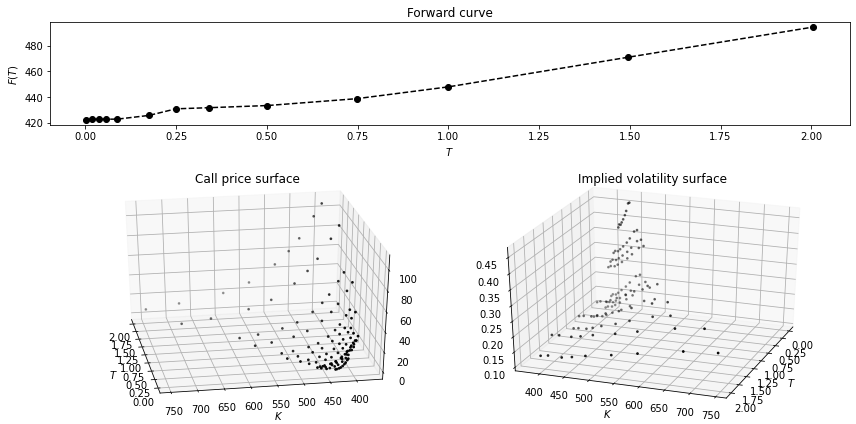

In [3]:
fig = plt.figure(figsize=(12,6))
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)

ax = fig.add_subplot(spec[0,:])  # plot the forward curve
ax.set_title('Forward curve')
unq_Ts, idx_T = np.unique(T, return_index=True)
ax.plot(unq_Ts, F[idx_T], '--ok')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$F(T)$')

ax = fig.add_subplot(spec[1:,0], projection='3d')
ax.set_title('Call price surface')
ax.scatter3D(T, K, C, s=3, color='k')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$K$')
ax.view_init(30,170)

ax = fig.add_subplot(spec[1:,1], projection='3d')
ax.set_title('Implied volatility surface')
ax.scatter3D(T, K, iv, s=3, color='k')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$K$')
ax.view_init(30,20)

plt.tight_layout()
plt.show()

### Normalise the data

Let us define $M_{T} = S_{T_i} / F_i$, $k^i_j = K^i_j/F_i$, $c^i_j = C^i_j / (D_i F_i)$, for all $i,j$. To have no static arbitrage, there exists $\mathbb{Q}$ such that
$$
c^i_j = \mathbb{E}^\mathbb{Q} \left[ \left. \left( \frac{S_{T_i}}{F_i} - \frac{K^i_j}{F_i} \right)^+ \right| \mathscr{F}_0 \right] = \mathbb{E}^\mathbb{Q} \left[ \left. \left( M_{T_i} - k^i_j \right)^+ \right| \mathscr{F}_0 \right],  \quad \forall i,j.
$$

Note that the call price data we have are the future values, or undiscounted values, of call options. Therefore, we do not require discount factor (i.e. zero rate curve) inputs.

In [4]:
# normalise strikes and prices
normaliser = constraints.Normalise()
normaliser.fit(T, K, C, F)
T1, K1, C1 = normaliser.transform(T, K, C)

_, _, C1_bid = normaliser.transform(T, K, C_bid)
_, _, C1_ask = normaliser.transform(T, K, C_ask)

##  Detect arbitrage

The static arbitrage constraints are linear inequalities of at most three call prices. Therefore, we can write these constraints in the form $A \mathbf{c} \geq \mathbf{b}$, where $\mathbf{c} = [c^1_1 \cdots c^1_{n_1} \cdots c^m_{n_m}]^\top \in \mathbb{R}^N$, $A  = (a_{ij}) \in \mathbb{R}^{R \times N}$ and $\mathbf{b} = (b_j) \in \mathbb{R}^{R}$ are a constant matrix and a vector corresponding to coefficients and bounds of the inequalities, respectively. Here, $R$ is the number of no-arbitrage constraints, where $R \sim \mathcal{O}(m^2 N)$.

When some row of the system of inequalities $A \mathbf{c} \geq \mathbf{b}$ is not satisfied, there is arbitrage. We identify, in our sample data, which types of arbitrage constraints are violated.

In [5]:
# construct arbitrage constraints and detect violation
mat_A, vec_b, _, _ = constraints.detect(T1, K1, C1, verbose=True)

Number of violations to non-negative outright price:                   0/13
Number of violations to non-negative and unit-bounded vertical spread: 0/130
Number of violations to non-negative butterfly spread:                 0/104
Number of violations to non-negative calendar (horizontal) spread:     0/0
Number of violations to non-negative calendar vertical spread:         9/513
Number of violations to non-negative calendar butterfly spread:        126/3070


## Repair arbitrage from the price data

We define $\boldsymbol{\varepsilon}$ to be the vector of perturbations added to the vector of call prices $\mathbf{c}$ such that the perturbed prices are arbitrage-free, i.e. $A (\mathbf{c} + \boldsymbol{\varepsilon}) \geq \mathbf{b}$. Hence, to remove arbitrage from the call price data, we seek the ``minimal'' repair subject to no-arbitrage constraints:

\begin{equation}
\underset{\boldsymbol\varepsilon \in \mathbb{R}^N}{\text{min}} f(\boldsymbol\varepsilon), \quad \text{subject to } A \boldsymbol{\varepsilon} \geq \mathbf{b} - A \mathbf{c},
\end{equation}

### Repair using two objective functions

We propose the following two objective functions:

- The $\ell^1$-norm repair (no bid-ask spread inputs are needed)

\begin{equation}
f(\boldsymbol{\varepsilon}) := ||\boldsymbol{\varepsilon}||_{\ell^1}.
\end{equation}

- The $\ell^1$-BA repair

\begin{equation}
f(\boldsymbol{\varepsilon}) = \sum_{j=1}^N \max \left( -\mathbf{e}_j^\top \boldsymbol{\varepsilon} -\delta^b_j+\delta_0, -\frac{\delta_0}{\delta^b_j} \mathbf{e}_j^\top \boldsymbol{\varepsilon}, \frac{\delta_0}{\delta^a_j} \mathbf{e}_j^\top \boldsymbol{\varepsilon}, \mathbf{e}_j^\top \boldsymbol{\varepsilon} - \delta^a_j + \delta_0 \right),
\end{equation}

where
- $\delta^b_j$ is the bid-mid spread
- $\delta^a_j$ is the ask-mid spread
- $\delta_0$ is a small non-negative constant
\begin{equation}
\delta_0 = \frac{1}{N} \wedge \min_{j=1,\dots,N} \left( \delta^a_j \wedge \delta^b_j \right).
\label{eq:delta_0}
\end{equation}



In [6]:
# repair arbitrage - l1-norm objective
epsilon1 = repair.l1(mat_A, vec_b, C1)

# repair arbitrage - l1ba objective
spread_ask = C1_ask - C1
spread_bid = C1 - C1_bid
spread = [spread_ask, spread_bid]

epsilon2 = repair.l1ba(mat_A, vec_b, C1, spread=spread)

### Compare the $\ell^1$-norm repair and the $\ell^1$-BA repair


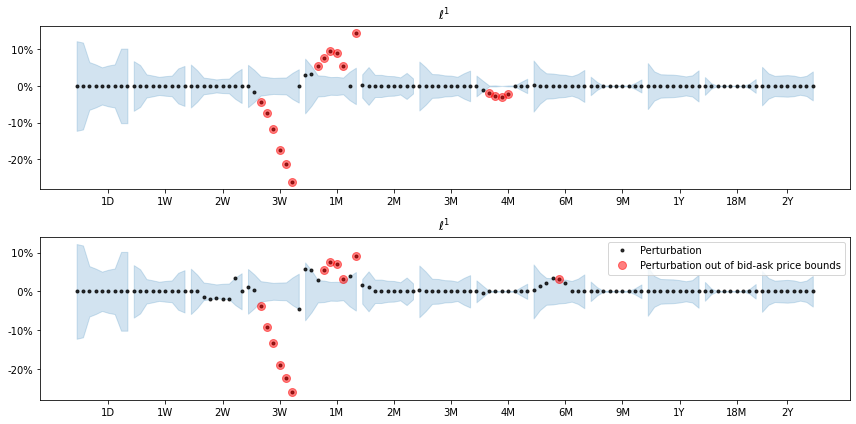

In [7]:
tol = 1e-8
n_quote = len(C1)
unq_Ts, idx_T = np.unique(T1, return_index=True)

expiry_str = ['1D', '1W', '2W', '3W', 
              '1M', '2M', '3M', '4M', '6M', '9M', '1Y', '18M', '2Y']

fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(211)
ax.plot(epsilon1/C1, 'ko', markersize=3, alpha=.8)
mask1 = epsilon1[epsilon1>0] - spread_ask[epsilon1>0] > tol
ax.plot(np.arange(n_quote)[epsilon1>0][mask1], 
        ((epsilon1/C1)[epsilon1>0])[mask1], 'ro', markersize=8, alpha=.5)
mask2 = epsilon1[epsilon1<0] + spread_bid[epsilon1<0] < -tol
ax.plot(np.arange(n_quote)[epsilon1<0][mask2], 
        ((epsilon1/C1)[epsilon1<0])[mask2], 'ro', markersize=8, alpha=.5)
for t in unq_Ts:
    mask_t = T1==t
    ax.fill_between(np.arange(n_quote)[mask_t], 
                    (-spread_bid/C1)[mask_t], (spread_ask/C1)[mask_t], color='C0', alpha=.2)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
ax.set_title(r"$\ell^1$")
ax.set_xticks(np.ceil((idx_T + np.hstack([idx_T[1:], len(T1)-1]))/2))
ax.set_xticklabels(expiry_str)

ax = fig.add_subplot(212)
ax.plot(epsilon2/C1, 'ko', markersize=3, alpha=.8, label='Perturbation')
mask1 = epsilon2[epsilon2>0] - spread_ask[epsilon2>0] > tol
ax.plot(np.arange(n_quote)[epsilon2>0][mask1], 
        ((epsilon2/C1)[epsilon2>0])[mask1], 'ro', markersize=8, alpha=.5)
mask2 = epsilon2[epsilon2<0] + spread_bid[epsilon2<0] < -tol
ax.plot(np.arange(n_quote)[epsilon2<0][mask2], 
        ((epsilon2/C1)[epsilon2<0])[mask2], 'ro', markersize=8, alpha=.5,
        label='Perturbation out of bid-ask price bounds')
for t in unq_Ts:
    mask_t = T1==t
    ax.fill_between(np.arange(n_quote)[mask_t], 
                    (-spread_bid/C1)[mask_t], (spread_ask/C1)[mask_t], color='C0', alpha=.2)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
ax.set_title(r"$\ell^1$")
ax.set_xticks(np.ceil((idx_T + np.hstack([idx_T[1:], len(T1)-1]))/2))
ax.set_xticklabels(expiry_str)
ax.legend()

plt.tight_layout()
plt.show()

From left to right, the displayed data are ordered by increasing strikes grouped by expiry. The light blue area are confined by bid-ask spread as a percentage of option prices (green lines). We see that ITM and OTM options have wider bid-ask spreads than ATM options do. The $\ell^1$-BA repair method results in fewer effective perturbations. First, there is one less effective perturbation of 1M option prices, at the cost of perturbing a few 2W, 3W and 1M option prices to their bid or ask prices. Second, all four effective perturbations of 4M option prices by the $\ell^1$-norm repair are replaced by six ineffective perturbations of 6M option prices by the $\ell^1$-BA repair.

In the following plot, we take a closer look at how these two repair methods perturb prices for a subset of expiries.

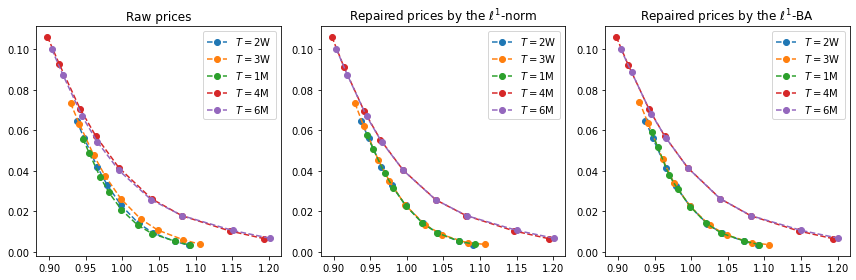

In [8]:
idx_T_sub = [2,3,4,7,8]

fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(131)
ax.set_title('Raw prices')
for i in idx_T_sub:
    mask_t = T1==unq_Ts[i]
    ax.plot(K1[mask_t], C1[mask_t], '--o', label=r'$T=$' + expiry_str[i])
ax.legend()

ax = fig.add_subplot(132)
ax.set_title(r'Repaired prices by the $\ell^1$-norm')
for i in idx_T_sub:
    mask_t = T1==unq_Ts[i]
    ax.plot(K1[mask_t], (C1+epsilon1)[mask_t], '--o', label=r'$T=$' + expiry_str[i])
ax.legend()

ax = fig.add_subplot(133)
ax.set_title(r'Repaired prices by the $\ell^1$-BA')
for i in idx_T_sub:
    mask_t = T1==unq_Ts[i]
    ax.plot(K1[mask_t], (C1+epsilon2)[mask_t], '--o', label=r'$T=$' + expiry_str[i])
ax.legend()

plt.tight_layout()
plt.show()